# Gradient-boosting decision tree (GBDT)

Neste notebook, apresentaremos o algoritmo de árvore de decisão de aumento de gradiente e o contrastaremos com AdaBoost.

O aumento de gradiente difere do AdaBoost devido ao seguinte motivo: em vez de atribuir pesos a amostras específicas, o GBDT ajustará uma árvore de decisão no erro de resíduos (daí o nome "gradiente") da árvore anterior. Portanto, cada nova árvore no conjunto prevê o erro cometido pelo aluno anterior, em vez de prever o alvo diretamente.

Nesta seção, forneceremos alguma intuição sobre como os alunos são combinados para dar a previsão final. A esse respeito, vamos voltar ao nosso problema de regressão, que é mais intuitivo para demonstrar o mecanismo subjacente.

In [1]:
import pandas as pd
import numpy as np

# Create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)


def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

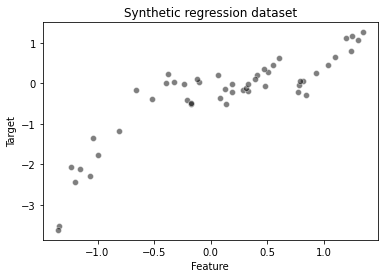

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

Como discutimos anteriormente, o boosting será baseado na montagem de uma sequência de alunos. Começaremos criando um regressor de árvore de decisão. Definiremos a profundidade da árvore de modo que o aluno resultante subestime os dados.

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

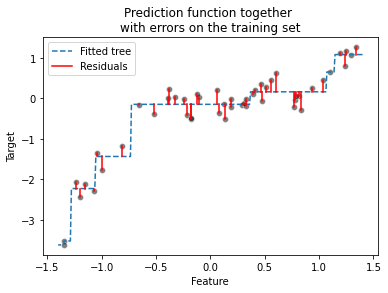

In [4]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test, target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")

In [5]:
residuals = target_train - target_train_predicted

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

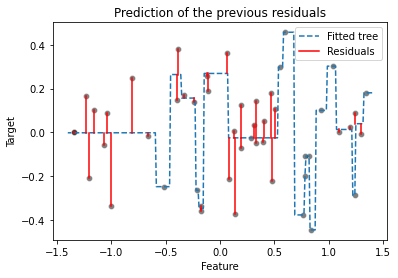

In [6]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(data_test, target_test_predicted_residuals, "--")

# plot the residuals of the predicted residuals
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction of the previous residuals")

Vemos que essa nova árvore só consegue ajustar alguns dos resíduos. Vamos nos concentrar em uma amostra específica do conjunto de treinamento (ou seja, sabemos que a amostra será bem classificada usando árvores sucessivas). Usaremos este exemplo para explicar como as previsões de ambas as árvores são combinadas. Vamos primeiro selecionar este exemplo em data_train.

In [7]:
data_max = data_train.iloc[-2, 0]
target_true = target_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

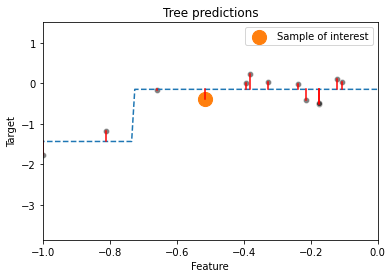

In [8]:
# Plot the previous information:
#   * the dataset
#   * the predictions
#   * the residuals

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test, target_test_predicted, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend()
_ = plt.title("Tree predictions")

Agora, vamos representar graficamente as informações residuais. Faremos um gráfico dos resíduos calculados a partir da primeira árvore de decisão e mostraremos as previsões residuais.

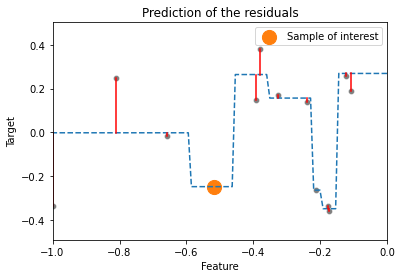

In [9]:
# Plot the previous information:
#   * the residuals committed by the first tree
#   * the residual predictions
#   * the residuals of the residual predictions

sns.scatterplot(x=data_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(data_test, target_test_predicted_residuals, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true_residual, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend()
_ = plt.title("Prediction of the residuals")

Para nossa amostra de interesse, nossa árvore inicial está cometendo um erro (pequeno resíduo). Ao ajustar a segunda árvore, o residual, neste caso, está perfeitamente ajustado e previsto. Verificaremos quantitativamente essa previsão usando a árvore ajustada. Primeiro, vamos verificar a previsão da árvore inicial e compará-la com o valor verdadeiro.

In [10]:
print(f"True value to predict for f(x={data_max:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict([[data_max]])[0]
print(f"Prediction of the first decision tree for x={data_max:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.517) = -0.393
Prediction of the first decision tree for x=-0.517: y=-0.145
Error of the tree: -0.248


Como observamos visualmente, temos um pequeno erro. Agora, podemos usar a segunda árvore para tentar prever esse resíduo.

In [11]:
print(f"Prediction of the residual for x={data_max:.3f}: "
      f"{tree_residuals.predict([[data_max]])[0]:.3f}")

Prediction of the residual for x=-0.517: -0.248


Vemos que nossa segunda árvore é capaz de prever o resíduo (erro) exato de nossa primeira árvore. Portanto, podemos prever o valor de x somando a previsão de todas as árvores no conjunto.

In [13]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict([[data_max]])[0]
)
print(f"Prediction of the first and second decision trees combined for "
      f"x={data_max:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=-0.517: y=-0.393
Error of the tree: 0.000


Escolhemos uma amostra para a qual apenas duas árvores foram suficientes para fazer a previsão perfeita. Porém, vimos na parcela anterior que duas árvores não foram suficientes para corrigir os resíduos de todas as amostras. Portanto, é necessário adicionar várias árvores ao conjunto para corrigir o erro com sucesso. (ou seja, a segunda árvore corrige o erro da primeira árvore, enquanto a terceira árvore corrige o erro da segunda árvore e assim por diante.)

Iremos comparar o desempenho de generalização de floresta aleatória e aumento de gradiente no conjunto de dados de habitação da Califórnia

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [16]:
print("Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.391 +/- 2.913 k$
Average fit time: 6.311 seconds
Average score time: 0.010 seconds


In [17]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=2)
cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [18]:
print("Random Forest")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{cv_results_rf['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random Forest
Mean absolute error via cross-validation: 46.533 +/- 4.570 k$
Average fit time: 20.243 seconds
Average score time: 0.153 seconds


Em termos de desempenho de computação, a floresta pode ser paralelizada e se beneficiará do uso de vários núcleos da CPU. Em termos de pontuação de desempenho, ambos os algoritmos levam a resultados muito próximos.

No entanto, vemos que o aumento do gradiente é um algoritmo muito rápido de prever em comparação com a floresta aleatória. Isso se deve ao fato de que o aumento do gradiente usa árvores rasas. Entraremos em detalhes no próximo bloco de notas sobre os hiperparâmetros a serem considerados ao otimizar métodos de ensemble.

# 📝 Exercício M6.04
O objetivo deste exercício é:

* verificar se um GBDT tende a super ajustar se o número de estimadores não é apropriado como visto anteriormente para AdaBoost;
* use a estratégia de parada antecipada para evitar adicionar árvores desnecessárias, para obter os melhores desempenhos de generalização.

Usaremos o conjunto de dados de habitação da Califórnia para conduzir nossos experimentos.

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

De forma semelhante ao exercício anterior, crie uma árvore de decisão de aumento de gradiente e crie uma curva de validação para avaliar o impacto do número de árvores no desempenho de generalização do modelo. Use o erro médio absoluto para avaliar o desempenho de generalização do modelo.

Crie uma árvore de decisão de aumento de gradiente com max_depth = 5 e learning_rate = 0,5.

In [4]:
# solution
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(max_depth=5, learning_rate=0.5)

Crie também uma floresta aleatória com árvores totalmente crescidas definindo max_depth=None.

In [5]:
# solution
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=None)

Ao contrário do AdaBoost, o modelo de aumento de gradiente sempre melhora ao aumentar o número de árvores no conjunto. No entanto, chegará a um platô onde adicionar novas árvores apenas tornará o encaixe e a pontuação mais lentos.

Para evitar a adição de uma nova árvore desnecessária, o aumento de gradiente oferece uma opção de parada antecipada. Internamente, o algoritmo usará um conjunto fora da amostra para calcular o desempenho de generalização do modelo a cada adição de uma árvore. Portanto, se o desempenho da generalização não melhorar por várias iterações, ele parará de adicionar árvores.

Agora, crie um modelo de aumento de gradiente com n_estimators = 1000. Este número de árvores será muito grande. Altere o parâmetro n_iter_no_change de modo que o ajuste de aumento de gradiente pare após adicionar 5 árvores que não melhoram o desempenho geral de generalização.

In [8]:
from sklearn.model_selection import validation_curve

param_range = [1, 2, 5, 10, 20, 50, 100]
gbdt_train_scores, gbdt_validation_scores = validation_curve(
    gbdt,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
gbdt_train_errors, gbdt_validation_errors = -gbdt_train_scores, -gbdt_validation_scores

forest_train_scores, forest_validation_scores = validation_curve(
    forest,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
forest_train_errors = -forest_train_scores
forest_validation_errors = -forest_validation_scores

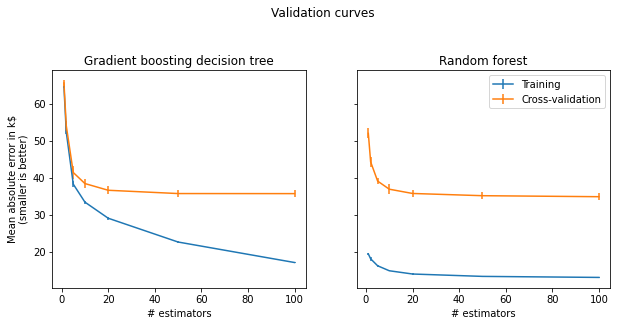

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 4))

axs[0].errorbar(
    param_range,
    gbdt_train_errors.mean(axis=1),
    yerr=gbdt_train_errors.std(axis=1),
    label="Training",
)
axs[0].errorbar(
    param_range,
    gbdt_validation_errors.mean(axis=1),
    yerr=gbdt_validation_errors.std(axis=1),
    label="Cross-validation",
)
axs[0].set_title("Gradient boosting decision tree")
axs[0].set_xlabel("# estimators")
axs[0].set_ylabel("Mean absolute error in k$\n(smaller is better)")

axs[1].errorbar(
    param_range,
    forest_train_errors.mean(axis=1),
    yerr=forest_train_errors.std(axis=1),
    label="Training",
)
axs[1].errorbar(
    param_range,
    forest_validation_errors.mean(axis=1),
    yerr=forest_validation_errors.std(axis=1),
    label="Cross-validation",
)
axs[1].set_title("Random forest")
axs[1].set_xlabel("# estimators")

plt.legend()
_ = fig.suptitle("Validation curves", y=1.1)

Ao contrário do AdaBoost, o modelo de aumento de gradiente sempre melhora ao aumentar o número de árvores no conjunto. No entanto, chegará a um platô onde adicionar novas árvores apenas tornará o encaixe e a pontuação mais lentos.

Para evitar a adição de uma nova árvore desnecessária, o aumento de gradiente oferece uma opção de parada antecipada. Internamente, o algoritmo usará um conjunto fora da amostra para calcular o desempenho de generalização do modelo a cada adição de uma árvore. Portanto, se o desempenho da generalização não melhorar por várias iterações, ele parará de adicionar árvores.

Agora, crie um modelo de aumento de gradiente com n_estimators = 1000. Este número de árvores será muito grande. Altere o parâmetro n_iter_no_change de modo que o ajuste de aumento de gradiente pare após adicionar 5 árvores que não melhoram o desempenho geral de generalização.

In [11]:
# solution
gbdt = GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)
gbdt.fit(data_train, target_train)
gbdt.n_estimators_

223

Vemos que o número de árvores usadas está muito abaixo de 1000 com o conjunto de dados atual. Treinar o modelo de aumento de gradiente com as 1.000 árvores inteiras teria sido inútil.

Estime o desempenho de generalização deste modelo novamente usando a métrica `sklearn.metrics.mean_absolute_error`, mas desta vez usando o conjunto de teste que realizamos no início do notebook. Compare o valor resultante com os valores observados na curva de validação.

In [12]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(target_test, gbdt.predict(data_test))
print(f"On average, our GBDT regressor makes an error of {error:.2f} k$")

On average, our GBDT regressor makes an error of 34.94 k$


Observamos que a medida do valor MAE no conjunto de teste realizado está próxima do erro de validação medido no lado direito da curva de validação. Isso é meio tranquilizador, pois significa que tanto o procedimento de validação cruzada quanto a divisão de teste de trem externo concordam aproximadamente como aproximações do verdadeiro desempenho de generalização do modelo. Podemos observar que a avaliação final do erro do teste parece estar até um pouco abaixo dos escores do teste validado cruzadamente. Isso pode ser explicado porque o modelo final foi treinado no conjunto de treinamento completo, enquanto os modelos de validação cruzada foram treinados em subconjuntos menores: em geral, quanto maior o número de pontos de treinamento, menor o erro de teste.